# Исследование взаимодействий ученых чеченской республики

**Описание исследования**

Цель исследования: смоделировать взаимодействия ученых Чеченской Республики, проверить гипотезу о существовании научных школ

Задачи:
- Собрать данные об статьях ученных, аффелированных с Чеченской Республикой с сайта e-library
- Обзор данных
- Обработать данные
- Привести данные в вид графа

**Описание данных:**

Таблица представляет собой информацию об статье, авторах и организации, в рамках которой статья была выпущена:

1. title - название статьи
2. author - имена авторов
3. organization - название организации (университета)

## Сбор данных: написание парсера

In [34]:
# Пишем парсер, для того, чтоб собрать необходимые данные
from selenium import webdriver
import chromedriver_autoinstaller
from selenium.webdriver.common.by import By
import pandas as pd

def parse_page(driver: webdriver.Chrome):
    result: list[dict[str, str]] = []
    elements = driver.find_elements(By.TAG_NAME, "tr")
    for element in elements:
        is_valid = bool(element.get_property("id"))
        if not is_valid:
            continue
        res = element.find_element(By.XPATH, "td[@align='left']").text.split("\n")
        title = res[0]
        author = res[1]
        result.append({"title": title, "author": author})
    return result

    def main():
        result: list[dict[str, str]] = []
        link = 'https://elibrary.ru/org_items.asp?orgsid=7486'
        chromedriver_autoinstaller.install()
        driver = webdriver.Chrome()
        driver.get(link)
        page_count = driver.find_element(
            By.XPATH, "//a[contains(text(), 'конец')]"
        ).get_attribute("href")
        page_count = int(page_count.split("(")[-1].strip(")"))
        for page in range(1, page_count - 1):
            driver.execute_script(f"javascript:goto_page({page})")
            page_result = parse_page(driver)
            result.extend(page_result)
        pd.DataFrame(result).to_excel('./result.xlsx', index=False)

    if __name__ == "__main__":
        main()

## Обзор данных

In [35]:
# Импорт необходимых библиотек
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import warnings
warnings.filterwarnings('ignore')

In [36]:
# Распаковка датасета
df = pd.read_excel('/Users/veronikafedosina/Documents/уник + работа/results.xlsx', sheet_name='Sheet1')

In [37]:
df

,title,author,organization
0,ЭЛЕКТИВНЫЙ КУРС «ОБЩИЕ МЕТОДЫ РЕШЕНИЯ УРАВНЕНИЙ»,"Бакашева А.Б., Батаева Я.Д.",ГРОЗНЕНСКИЙ ГОСУДАРСТВЕННЫЙ НЕФТЯНОЙ ТЕХНИЧЕСК...
1,РЕШЕНИЕ ТРИГОНОМЕТРИЧЕСКИХ УРАВНЕНИЙ И НЕРАВЕНСТВ,Бакашева А.Б.,ГРОЗНЕНСКИЙ ГОСУДАРСТВЕННЫЙ НЕФТЯНОЙ ТЕХНИЧЕСК...
2,ОСНОВЫ СОВРЕМЕННОГО БАНКИНГА,"Таштамиров М.Р., Тавбулатова З.К.",ГРОЗНЕНСКИЙ ГОСУДАРСТВЕННЫЙ НЕФТЯНОЙ ТЕХНИЧЕСК...
3,ОСНОВЫ МЕЖДУНАРОДНОГО БАНКИНГА,"Тавбулатова З.К., Таштамиров М.Р.",ГРОЗНЕНСКИЙ ГОСУДАРСТВЕННЫЙ НЕФТЯНОЙ ТЕХНИЧЕСК...
4,МЕТОДИЧЕСКИЕ РЕКОМЕНДАЦИИ ПО ВЫПОЛНЕНИЮ И ЗАЩИ...,МАГИСТЕРСКАЯ ДИССЕРТАЦИЯ (направление подготов...,ГРОЗНЕНСКИЙ ГОСУДАРСТВЕННЫЙ НЕФТЯНОЙ ТЕХНИЧЕСК...
...,...,...,...
46585,ИНТЕГРАЛЬНОЕ ИСЧИСЛЕНИЕ ФУНКЦИИ ОДНОЙ ПЕРЕМЕННОЙ,Асхабов С.Н.,ЧЕЧЕНСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ ИМ. А.А....
46586,ПРОБЛЕМЫ РАЗВИТИЯ ФЕРМЕРСКИХ ХОЗЯЙСТВ В ЧЕЧЕНС...,Авторханов А.И.,ЧЕЧЕНСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ ИМ. А.А....
46587,ОСОБЕННОСТИ РАЗВИТИЯ ВИНОГРАДАРСТВА И ВИНОДЕЛИ...,Батукаев А.А.,ЧЕЧЕНСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ ИМ. А.А....
46588,СВЯЗАННЫЕ ЗАДАЧИ СЕЙСМОДИНАМИКИ ТРУБОПРОВОДА,Исраилов М.Ш.,ЧЕЧЕНСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ ИМ. А.А....


In [38]:
# Осн. информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46590 entries, 0 to 46589
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         46590 non-null  object
 1   author        46590 non-null  object
 2   organization  46590 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [39]:
# поиск и удаление дубликатов
df.duplicated().sum()

633

**Вывод:**
- Всего собрано 46590 статьей
- Пропусков в таблице нет
- Есть аномалии, попавшие в столбец авторов
- Найдено 633 дубликата

## Подготовка данных

In [40]:
# Удаляем дубликаты
df = df.drop_duplicates()

In [41]:
# Разделяем имена авторов на разные колонки
df[['author_0', 'author_1', 'author_2', 'author_3', 'author_4', 'author_5', 'author_6', 'author_7', 'author_8', 'author_9', 'author_10', 'author_11', 'author_12', 'author_13', 'author_14', 'author_15', 'author_16', 'author_17', 'author_18', 'author_19']] = df['author'].str.split(',', expand=True)

In [42]:
# Удаляем пропуски в столбце author_0 и author_1, чтобы исключить статьи без авторов и с одним автором
df = df.dropna(subset=['author_0', 'author_1'])

In [43]:
# Функция для подсчета пробелов в каждой строчке author, чтобы удалить не имена
def counter(series):
    i = series.count(' ')
    return i

In [44]:
# считаем кол-во пробелов
df['number'] = df['author_0'].apply(counter)

In [45]:
# Удаляем ненужные значения 
df = df.query('number==1')

In [46]:
# Удаляем колонки с авторами
df = df[['title', 'author', 'organization']]

In [47]:
# Удаляем статьи на английском, так как скорее всего они продублированы на русском, назначаем индекс статьям
df = df.sort_values(by='author')[2331:-1].reset_index()

In [48]:
# Разделяем для будущего графа имена авторов на разные строки
df = df.assign(author=df['author'].str.split(',')).explode('author')

In [49]:
# Проверим существуют ли другие выбивающиеся значения в столбце author
df.sort_values(by='author').head()

,index,title,author,organization
20712,2934,ПРОИЗВОДСТВЕННАЯ АТС НА ПРИМЕРЕ ПЛАТФОРМЫ ASTE...,.Исаева М.З.,ГРОЗНЕНСКИЙ ГОСУДАРСТВЕННЫЙ НЕФТЯНОЙ ТЕХНИЧЕСК...
18396,9769,КОНСТИТУЦИИ ЧЕЧЕНСКОЙ РЕСПУБЛИКИ: ОТ ПЕРВОЙ КО...,2013.,КОМПЛЕКСНЫЙ НАУЧНО-ИССЛЕДОВАТЕЛЬСКИЙ ИНСТИТУТ ...
18397,23535,КОНСТИТУЦИИ ЧЕЧЕНСКОЙ РЕСПУБЛИКИ: ОТ ПЕРВОЙ КО...,2013.,АКАДЕМИЯ НАУК ЧЕЧЕНСКОЙ РЕСПУБЛИКИ
1644,5214,СОВРЕМЕННАЯ НАУКА: АКТУАЛЬНЫЕ ПРОБЛЕМЫ И ПЕРСП...,Aхмадова Х.Х.,ГРОЗНЕНСКИЙ ГОСУДАРСТВЕННЫЙ НЕФТЯНОЙ ТЕХНИЧЕСК...
55,12623,ИННОВАЦИОННОЕ РАЗВИТИЕ НАУКИ: ФУНДАМЕНТАЛЬНЫЕ ...,Bagateyeva A.O.,ЧЕЧЕНСКИЙ ГОСУДАРСТВЕННЫЙ ПЕДАГОГИЧЕСКИЙ УНИВЕ...


In [50]:
# Удаляем попавшие в столбец авторов выбивающиеся значения
df = df.sort_values(by='author')[3:-1]
df = df.sort_values(by='author')[5:-1]
df

,index,title,author,organization
10117,2040,MODELS OF THE MODERN EDUCATION PARADIGM IN THE...,Mamadieva M.Kh.,ГРОЗНЕНСКИЙ ГОСУДАРСТВЕННЫЙ НЕФТЯНОЙ ТЕХНИЧЕСК...
15163,8364,REGIONAL SPECIFICITY OF TOPONYM SEMANTICS: PSY...,Sternin I.А.,КОМПЛЕКСНЫЙ НАУЧНО-ИССЛЕДОВАТЕЛЬСКИЙ ИНСТИТУТ ...
18836,37147,К ВОПРОСУ ОБ ИМПОРТОЗАМЕЩЕНИИ В РОССИИ,Tерхоева Т.С.,ЧЕЧЕНСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ ИМ. А.А....
18835,37257,ПРОБЛЕМЫ СТАНОВЛЕНИЯ И РАЗВИТИЯ ФОНДОВОГО РЫНК...,Tерхоева Т.С.,ЧЕЧЕНСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ ИМ. А.А....
55,12623,ИННОВАЦИОННОЕ РАЗВИТИЕ НАУКИ: ФУНДАМЕНТАЛЬНЫЕ ...,Vildanova E.M.,ЧЕЧЕНСКИЙ ГОСУДАРСТВЕННЫЙ ПЕДАГОГИЧЕСКИЙ УНИВЕ...
...,...,...,...,...
24432,35817,ФУНКЦИОНАЛЬНЫЕ МАТЕРИАЛЫ НА ОСНОВЕ НИОБАТОВ ЩЕ...,Яцковский Э.Д.,ЧЕЧЕНСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ ИМ. А.А....
24433,30013,ОСОБЕННОСТИ СОЦИАЛЬНОЙ РАБОТЫС МОЛОДЕЖЬЮ В РОС...,Яшадов М.Х.,ЧЕЧЕНСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ ИМ. А.А....
24434,39082,ХIИНЦАЛЕРА НОХЧИЙН ЛИТЕРАТУРА КХИАР,Яшадова Х.В.,ЧЕЧЕНСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ ИМ. А.А....
24436,32384,ФОЛЬКЛОРНОЕ НАСЛЕДИЕ МАГОМЕДА САЛЬМУРЗАЕВА,Яшадова Х.Х.,ЧЕЧЕНСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ ИМ. А.А....


In [51]:
# Повторно считаем кол-во пробелов и удаляем строки с большим кол-вом
df['number'] = df['author'].apply(counter)
df = df.query('number < 3')

**Вывод:**

- Данные успешно отчищены от дубликатов и возможных англоязычных дубликатов
- Удалены аномалии из столбца авторов
- Для будущего графа авторы разделены на разные строки

## Анализ и построение графа

In [52]:
# Создаем связки вершин
df_edges = df[['index', 'author']]
df_edges = df_edges.merge(df_edges, on='index')
df_edges

,index,author_x,author_y
0,2040,Mamadieva M.Kh.,Mamadieva M.Kh.
1,2040,Mamadieva M.Kh.,Бабатова А.
2,2040,Mamadieva M.Kh.,Залибекова А.
3,2040,Бабатова А.,Mamadieva M.Kh.
4,2040,Бабатова А.,Бабатова А.
...,...,...,...
241650,19256,Воронов Л.Н.,Воронов Л.Н.
241651,5469,Апкаров И.А.,Апкаров И.А.
241652,36677,Зармаев А.А.,Зармаев А.А.
241653,9769,Сборник конституций,Сборник конституций


In [53]:
# Удаляем повторяющиеся в обеих колонках имена
df_edges = df_edges[~(df_edges['author_x']==df_edges['author_y'])] \
.dropna()
df_edges

,index,author_x,author_y
1,2040,Mamadieva M.Kh.,Бабатова А.
2,2040,Mamadieva M.Kh.,Залибекова А.
3,2040,Бабатова А.,Mamadieva M.Kh.
5,2040,Бабатова А.,Залибекова А.
6,2040,Залибекова А.,Mamadieva M.Kh.
...,...,...,...
241641,12507,Хатуева А.К.,Яхьяева Р.Б.
241644,13090,Яхьяева Р.М.,Асламбекова Р.М.
241645,13090,Асламбекова Р.М.,Яхьяева Р.М.
241648,19256,омельченко П.Н.,Воронов Л.Н.


In [54]:
# Избавляемся от дубликатов взаимодействий, считаем их количество
df_edges = df_edges.groupby(["author_x", "author_y"]).size().reset_index(name="count")
df_edges

,author_x,author_y,count
0,Mamadieva M.Kh.,Бабатова А.,1
1,Mamadieva M.Kh.,Залибекова А.,1
2,Sternin I.А.,Ибрагимов Д.К.,1
3,Sternin I.А.,Махаев М.Р.,1
4,Tерхоева Т.С.,Барзаева М.А.,1
...,...,...,...
87159,Яшадов М.Х.,Абдулаева Э.С.,1
87160,Яшадова Х.В.,Расумов В.Ш.,1
87161,Яшадова Х.Х.,Козуева Х.М.,1
87162,Яшадова Х.Х.,Расумов В.Ш.,1


In [55]:
# Проверяем на наличие дубликатов
df_edges.duplicated(subset=['author_x', 'author_y']).sum()

0

In [56]:
# Удаляем пары с небольшим числом взаимодействий
df_edges = df_edges.query('count>2')

In [57]:
# Изучим количество взаимодействий
df_edges.sort_values(by='count', ascending=False)

,author_x,author_y,count
18006,Гарсаева М.М.,Гарсаев Л.М.,233
73313,Гарсаев Л.М.,Гарсаева М.М.,233
77295,Керимов И.А.,Даукаев А.А.,132
21416,Даукаев А.А.,Керимов И.А.,132
82779,Тайсумов М.А.,Астамирова М.А.М.,114
...,...,...,...
37275,Магомадов А.С.,Хамзатова М.Х.,3
37268,Магомадов А.С.,Макарова А.Г.,3
37263,Магомадов А.С.,Занилов А.Х.,3
37262,Магомадов А.С.,Дикаев З.С.,3


In [58]:
df_edges['count'].describe()

count    13848.000000
mean         6.046938
std          7.563503
min          3.000000
25%          3.000000
50%          4.000000
75%          6.000000
max        233.000000
Name: count, dtype: float64

In [59]:
# Для таблицы с вершинами создаем список уникальных значений авторов
a_list = df_edges['author_x'].to_list()

In [60]:
# Cоздаем таблицу с вершинами
df_nodes = df.query('author in @a_list').groupby('author').agg({'organization':'max'}).reset_index()
df_nodes

,author,organization
0,Абаев Д.С.,ГРОЗНЕНСКИЙ ГОСУДАРСТВЕННЫЙ НЕФТЯНОЙ ТЕХНИЧЕСК...
1,Абакумова И.В.,ЧЕЧЕНСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ ИМ. А.А....
2,Абасов М.Ш.,ЧЕЧЕНСКИЙ НАУЧНО-ИССЛЕДОВАТЕЛЬСКИЙ ИНСТИТУТ СЕ...
3,Абасов Ш.М.,ЧЕЧЕНСКИЙ НАУЧНО-ИССЛЕДОВАТЕЛЬСКИЙ ИНСТИТУТ СЕ...
4,Абдуев М.Х.,ЧЕЧЕНСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ ИМ. А.А....
...,...,...
3266,Ясадова С.А.,ЧЕЧЕНСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ ИМ. А.А....
3267,Яударова М.Ю.,ЧЕЧЕНСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ ИМ. А.А....
3268,Яхъяева З.И.,ЧЕЧЕНСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ ИМ. А.А....
3269,Яхьяев М.Я.,КОМПЛЕКСНЫЙ НАУЧНО-ИССЛЕДОВАТЕЛЬСКИЙ ИНСТИТУТ ...


In [61]:
# Для того, чтоб организации были рзного цвета, добавляем номер каждой организации
groups = df_nodes.groupby('organization')['author'].apply(list).reset_index()
groups['group'] = groups.index

# Находим номер группы для каждой вершины
df_nodes = df_nodes.merge(groups, how="inner", on=['organization'])
df_nodes['title'] = df_nodes[['author_x', 'organization']].apply(lambda x: f'author_x:{x[0]} , organization:{x[1]}', axis=1)

# Удаляем ненужный столбец, назначаем author_x в качестве индекса
df_nodes = df_nodes.drop('author_y', axis=1).set_index('author_x')

# Собираем атрибуты вершин для networkx
node_attrs = df_nodes.to_dict('index')

In [62]:
# Cоздаем граф в netwokx, добавляем атрибуты с названием организации для каждой вершины
G=nx.from_pandas_edgelist(df_edges, 'author_x', 'author_y', 'count')
nx.set_node_attributes(G, node_attrs)

In [64]:
# Назначаем граф в pyviz, визуализируем
nt = Network()
nt.from_nx(G)
nt.show('nx.html')

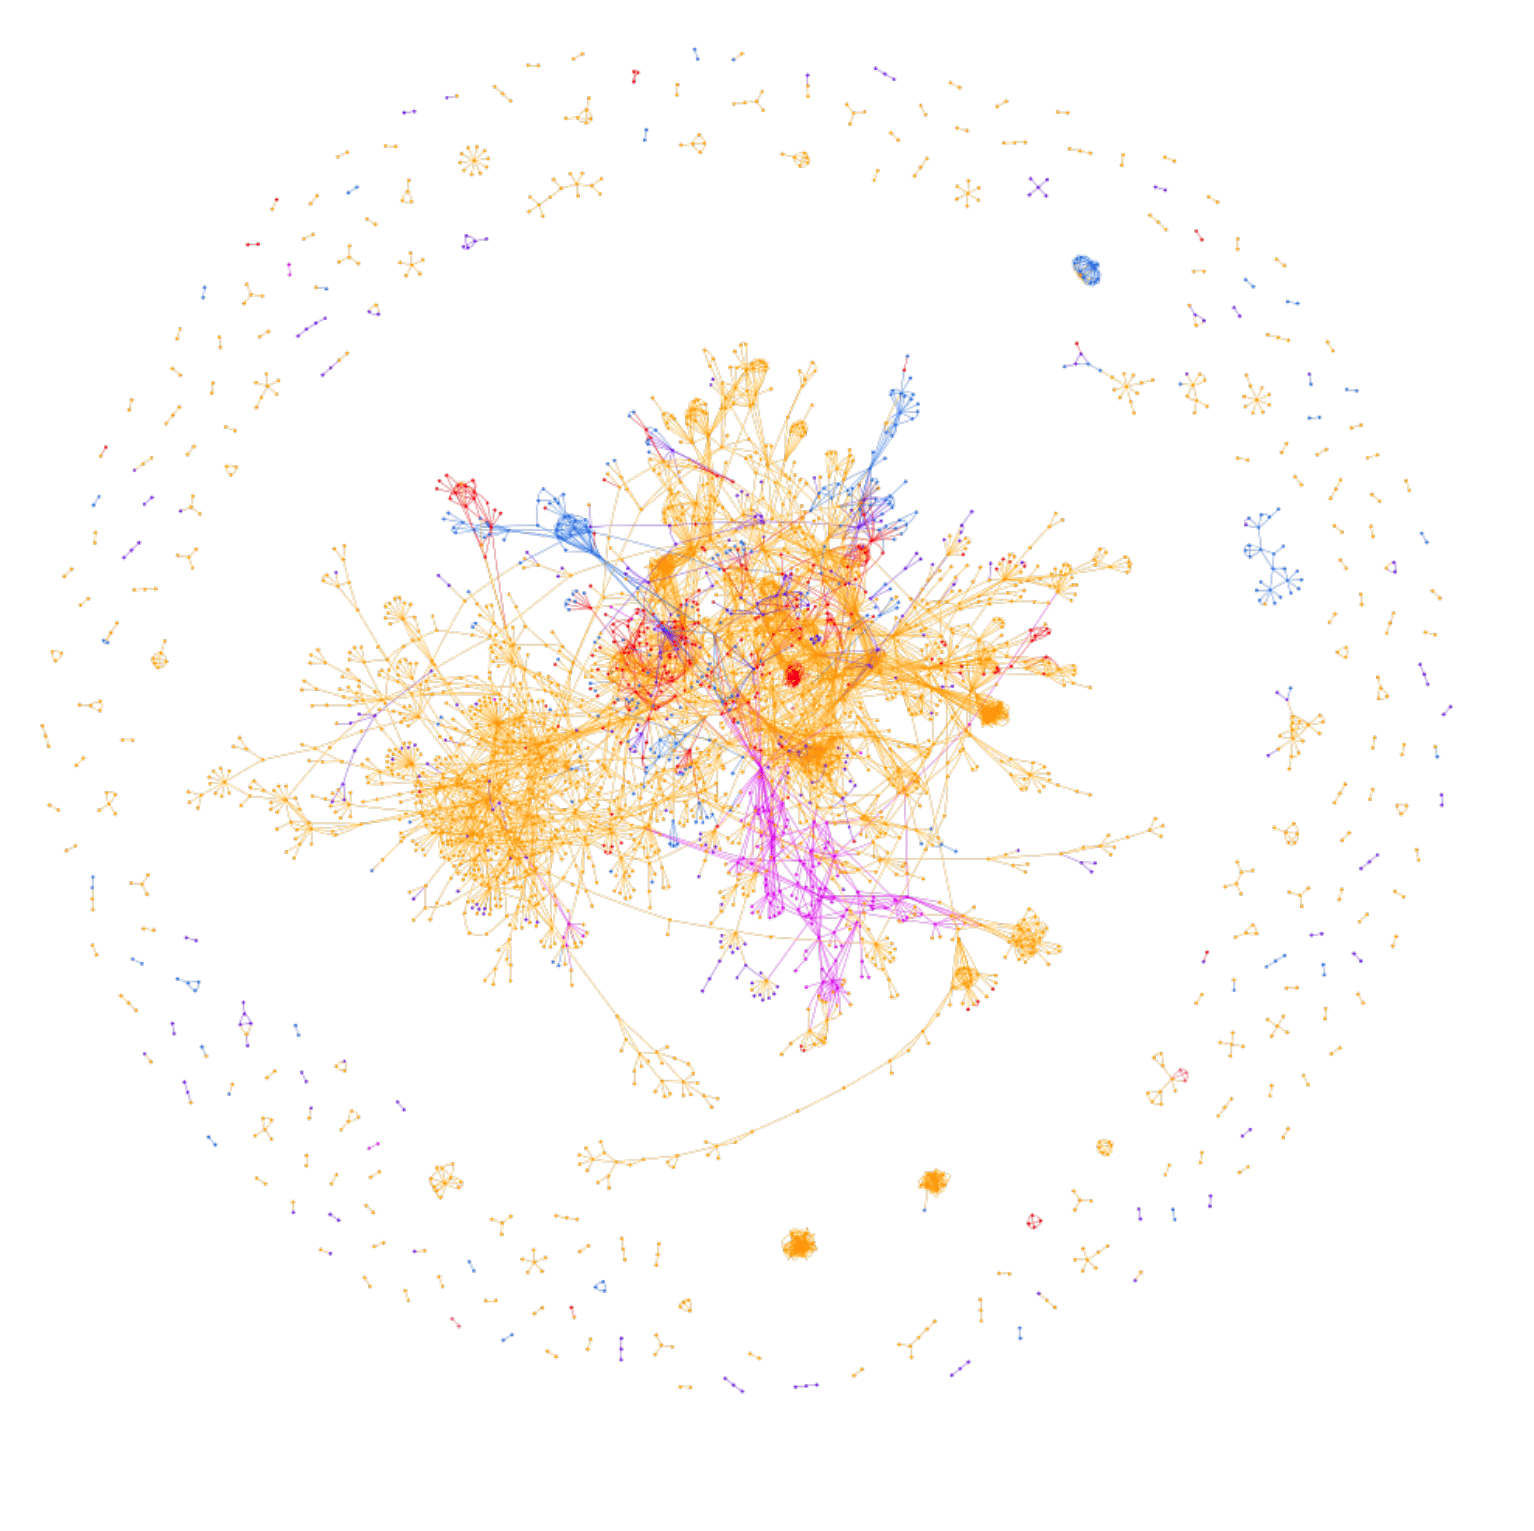

In [65]:
# Так как в github не отображается html выведем картину графа
from IPython.display import Image
Image('/Users/veronikafedosina/Documents/nx-1.png')

**Вывод:**

- Данные приведены в вид графа, снижена размерность графа
- Посчитаны взаимодействия: есть пары авторов, которые писали совместные статьи более 100 раз, в основном количество взаимодейстсвий находятся от 2 до 6.
- Данные визуализированы в интерактивный граф, при наведении на вершину можно увидеть имя автора и к какой организации он относится 

## Общий вывод

Таким образом, исследование было выполнено в четыре этапа:

1. Сбор данных: мной был написан парсер для сайта e-library, данные успешно собраны
2. Обзор данных: на этом этапе я изучила данные на предмет пропусков, дубликатов и прочих аномалий.
3. Подготовка данных: данные были отчищены от дубликатов, неявных дубликатов и аномалий, соавторы были разделены на разные строки для дальнешего построения графа
4. Анализ и построение графа: на данном этапе были созданы датафреймы с ребрами (связями) и вершинами (авторами), снижена размерность графа, изучено распределение числа взаимодействий пар авторов, также мной был визуализирован граф.

**Анализ и построение графа: выводы**


- На графике видно, что есть небольшие скопления ученых, между собой не взаимодействующих, однако большинство находятся в тесной связи и представляют собой большую академическую сеть
- Среди самостоятельных групп наиболее многочисленными являются объединения ученных Грозненского Государственного Нефтянного Технического Университета.
- Представители разных организаций также активно взаимодействуют между собой, в основном связь происходит через представителей Чеченского Государственного Университета им. А.А. Кадырова
- Выделяются наиболее активные авторы, через которых связываются разные группы внутри большой академической сети.